# Cycle Generative Adversarial Network

In [1]:
import os
import math
import time
import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.utils as vutils
import torchvision.transforms as transforms

In [3]:
from models import GeneratorResNet, Discriminator, weights_init_normal
from datasets import ImageDataset
from utils import ReplayBuffer, LambdaLR

## Set Arguments

In [4]:
epoch = 0
n_epochs = 200
dataset_name = 'horse2zebra'
batch_size = 1
lr = 0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 100
n_cpu = 8
n_gpu = 1
img_height = 256
img_width = 256
channels = 3
sample_interval = 1000
checkpoint_interval = -1
n_residual_blocks = 9
lambda_cyc = 10.0
lambda_id = 0.5

In [5]:
input_shape = (channels, img_height, img_width)

In [6]:
cuda = torch.cuda.is_available()

## Configure Data Loader

#### Buffers of previously generated samples

In [7]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

#### Image transformations

In [8]:
transforms_ = [
    transforms.Resize(int(img_height * 1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

#### Training and test data loader

In [9]:
data_loader = DataLoader(
    ImageDataset("./data/%s" % dataset_name, transforms_=transforms_, unaligned=True),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

print('Total batches:',len(data_loader))

Total batches: 1334


In [10]:
val_data_loader = DataLoader(
    ImageDataset("./data/%s" % dataset_name, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=1,
)

print('Total batches:',len(val_data_loader))

Total batches: 28


In [11]:
device = torch.device('cuda:0' if (torch.cuda.is_available() and n_gpu > 0) else 'cpu')

## Look Training Images

In [12]:
if not os.path.exists("images/%s/" % (dataset_name)):
    os.makedirs("images/%s/" % (dataset_name))

In [13]:
def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_data_loader))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = vutils.make_grid(real_A, nrow=5, normalize=True)
    real_B = vutils.make_grid(real_B, nrow=5, normalize=True)
    fake_A = vutils.make_grid(fake_A, nrow=5, normalize=True)
    fake_B = vutils.make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "images/%s/%s.png" % (dataset_name, batches_done), normalize=False)

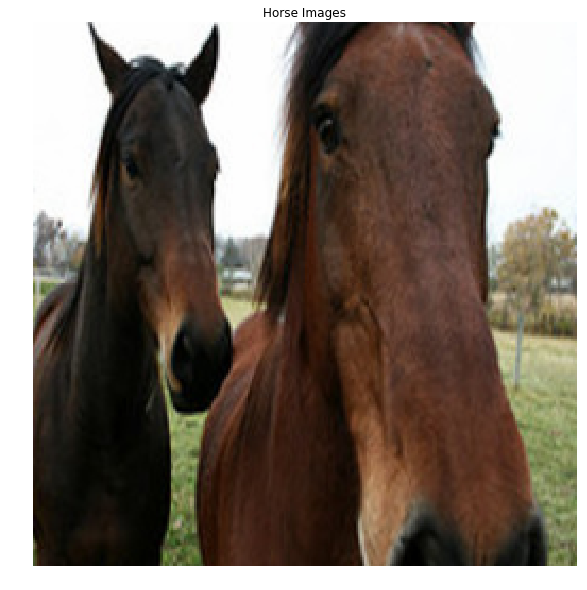

In [14]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(10,10))
plt.axis('off')
image_name = dataset_name.split('2')[0].capitalize()
plt.title('%s Images' % image_name)
plt.imshow(np.transpose(vutils.make_grid(real_batch['A'][0].to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

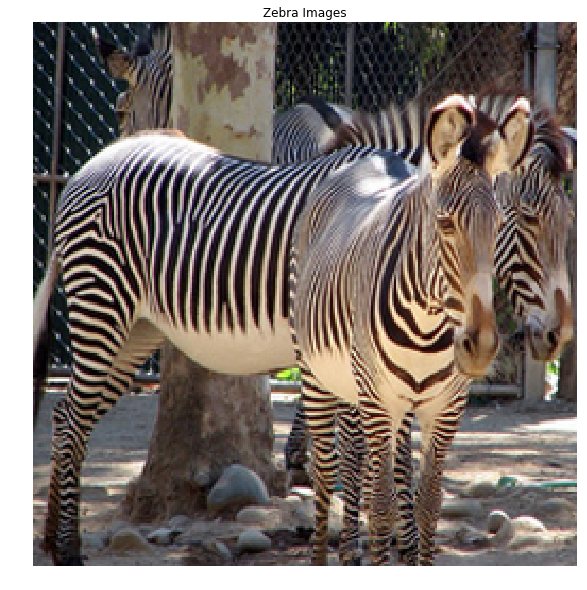

In [15]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(10,10))
plt.axis('off')
image_name = dataset_name.split('2')[1].capitalize()
plt.title('%s Images' % image_name)
plt.imshow(np.transpose(vutils.make_grid(real_batch['B'][0].to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

## Build GAN Architecture

#### Initialize the generator and discriminator

In [16]:
G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()

#### Initialize Weights

In [17]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

## Set Loss Function

In [18]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

if cuda:
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

## Set Optimizers

In [19]:
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()),
    lr=lr,
    betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

In [20]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

## Set Learning Rate Update Schedulers

In [21]:
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

## Train [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf)

In [ ]:
g_loss_to_display = []
d_loss_to_display = []
prev_time = time.time()
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(data_loader):
        
        # set model input
        real_A = Variable(batch['A'].type(Tensor))
        real_B = Variable(batch['B'].type(Tensor))
        
        # adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)   
        
        # -------------------
        # Train Generators
        # -------------------
        
        G_AB.train()
        G_BA.train()
        
        optimizer_G.zero_grad()
        
        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # Total loss
        loss_G = lambda_id * loss_identity + loss_GAN + lambda_cyc * loss_cycle
        loss_G.backward()
        
        optimizer_G.step()
        
        
        # ----------------------
        # Train Discriminator A
        # ----------------------
        
        optimizer_D_A.zero_grad()
        
        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2
        loss_D_A.backward()
        
        optimizer_D_A.step()
        
        
        # ----------------------
        # Train Discriminator B
        # ----------------------
        
        optimizer_D_B.zero_grad()
        
        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D_B.backward()
        
        optimizer_D_B.step()
        
        # loss Discriminator A & B
        loss_D = (loss_D_A + loss_D_B) / 2
        
        # save losses for plotting later
        g_loss_to_display.append(loss_G.item())
        d_loss_to_display.append(loss_D.item())
        
        # --------------
        # Log Progress
        # --------------
        
        # determine approximate time left
        batches_done = epoch * len(data_loader) + i
        batches_left = n_epochs * len(data_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()
        
        # print log
        print(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, identity: %f, adv: %f, cycle: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(data_loader),
                loss_D.item(),
                loss_G.item(),
                loss_identity.item(),
                loss_GAN.item(),
                loss_cycle.item(),
                time_left,
            )
        )
        
        # if at sample interval save image
        if batches_done % sample_interval == 0:
            sample_images(batches_done)
            
    # update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # save model checkpoints
        torch.save(G_AB.state_dict(), "weights/%s/G_AB_%d.pth" % (dataset_name, epoch))
        torch.save(G_BA.state_dict(), "weights/%s/G_BA_%d.pth" % (dataset_name, epoch))
        torch.save(D_A.state_dict(), "weights/%s/D_A_%d.pth" % (dataset_name, epoch))
        torch.save(D_B.state_dict(), "weights/%s/D_B_%d.pth" % (dataset_name, epoch))

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_to_display, label="Generator Loss")
plt.plot(d_loss_to_display, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.savefig('./images/{}/final_loss.png'.format(dataset_name))
plt.show()

## Show Final Images

In [ ]:
import os
from PIL import Image

In [ ]:
final_images = os.listdir('./images/{}/'.format(dataset_name))[-1]
Image.open('./images/{}/{}'.format(dataset_name, final_images))

---